## Create Model

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings
from keras.models import Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D
from keras import initializers, regularizers, constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions, _obtain_input_shape
from keras import backend as K

BASE_WEIGHT_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.6/'


def relu6(x):
    return K.relu(x, max_value=6)


def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Preprocessed array.
    """
    return imagenet_utils.preprocess_input(x, mode='tf')


class DepthwiseConv2D(Conv2D):
    def __init__(self,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 depth_multiplier=1,
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 depthwise_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 depthwise_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 depthwise_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(DepthwiseConv2D, self).__init__(
            filters=None,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            bias_constraint=bias_constraint,
            **kwargs)
        self.depth_multiplier = depth_multiplier
        self.depthwise_initializer = initializers.get(depthwise_initializer)
        self.depthwise_regularizer = regularizers.get(depthwise_regularizer)
        self.depthwise_constraint = constraints.get(depthwise_constraint)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        if len(input_shape) < 4:
            raise ValueError('Inputs to `DepthwiseConv2D` should have rank 4. '
                             'Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = 3
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs to '
                             '`DepthwiseConv2D` '
                             'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        depthwise_kernel_shape = (self.kernel_size[0], self.kernel_size[1],
                                  input_dim, self.depth_multiplier)

        self.depthwise_kernel = self.add_weight(
            shape=depthwise_kernel_shape,
            initializer=self.depthwise_initializer,
            name='depthwise_kernel',
            regularizer=self.depthwise_regularizer,
            constraint=self.depthwise_constraint)

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(input_dim * self.depth_multiplier, ),
                initializer=self.bias_initializer,
                name='bias',
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        outputs = K.depthwise_conv2d(
            inputs,
            self.depthwise_kernel,
            strides=self.strides,
            padding=self.padding,
            dilation_rate=self.dilation_rate,
            data_format=self.data_format)

        if self.bias:
            outputs = K.bias_add(
                outputs, self.bias, data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)

        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            rows = input_shape[2]
            cols = input_shape[3]
            out_filters = input_shape[1] * self.depth_multiplier
        elif self.data_format == 'channels_last':
            rows = input_shape[1]
            cols = input_shape[2]
            out_filters = input_shape[3] * self.depth_multiplier

        rows = conv_utils.conv_output_length(rows, self.kernel_size[0],
                                             self.padding, self.strides[0])
        cols = conv_utils.conv_output_length(cols, self.kernel_size[1],
                                             self.padding, self.strides[1])

        if self.data_format == 'channels_first':
            return (input_shape[0], out_filters, rows, cols)
        elif self.data_format == 'channels_last':
            return (input_shape[0], rows, cols, out_filters)

    def get_config(self):
        config = super(DepthwiseConv2D, self).get_config()
        config.pop('filters')
        config.pop('kernel_initializer')
        config.pop('kernel_regularizer')
        config.pop('kernel_constraint')
        config['depth_multiplier'] = self.depth_multiplier
        config['depthwise_initializer'] = initializers.serialize(
            self.depthwise_initializer)
        config['depthwise_regularizer'] = regularizers.serialize(
            self.depthwise_regularizer)
        config['depthwise_constraint'] = constraints.serialize(
            self.depthwise_constraint)
        return config


def MobileNet(input_shape=None,
              alpha=1.0,
              depth_multiplier=1,
              dropout=1e-3,
              include_top=True,
              weights='imagenet',
              input_tensor=None,
              pooling=None,
              classes=1000,
              shallow=False):

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported, '
                           'as other backends do not support '
                           'depthwise convolution.')

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as ImageNet with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    if input_shape is None:
        default_size = 224
    else:
        if K.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = _obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=K.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if K.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if depth_multiplier != 1:
            raise ValueError('If imagenet weights are being loaded, '
                             'depth multiplier must be 1')

        if alpha not in [0.25, 0.50, 0.75, 1.0]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of'
                             '`0.25`, `0.50`, `0.75` or `1.0` only.')

        if rows != cols or rows not in [128, 160, 192, 224]:
            raise ValueError('If imagenet weights are being loaded, '
                             'input must have a static square shape (one of '
                             '(128,128), (160,160), (192,192), or (224, 224)).'
                             ' Input shape provided = %s' % (input_shape, ))

    if K.image_data_format() != 'channels_last':
        warnings.warn('The MobileNet family of models is only available '
                      'for the input data format "channels_last" '
                      '(width, height, channels). '
                      'However your settings specify the default '
                      'data format "channels_first" (channels, width, height).'
                      ' You should set `image_data_format="channels_last"` '
                      'in your Keras config located at ~/.keras/keras.json. '
                      'The model being returned right now will expect inputs '
                      'to follow the "channels_last" data format.')
        K.set_image_data_format('channels_last')
        old_data_format = 'channels_first'
    else:
        old_data_format = None

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, strides=(2, 2), block_id=6)

    if not shallow:
        x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
        x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
        x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
        x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
        x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    if include_top:
        if K.image_data_format() == 'channels_first':
            shape = (int(1024 * alpha), 1, 1)
        else:
            shape = (1, 1, int(1024 * alpha))

        x = GlobalAveragePooling2D()(x)
        x = Reshape(shape, name='reshape_1')(x)
        x = Dropout(dropout, name='dropout')(x)
        x = Conv2D(classes, (1, 1), padding='same', name='conv_preds')(x)
        x = Activation('softmax', name='act_softmax')(x)
        x = Reshape((classes, ), name='reshape_2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            raise ValueError('Weights for "channels_last" format '
                             'are not available.')
        if alpha == 1.0:
            alpha_text = '1_0'
        elif alpha == 0.75:
            alpha_text = '7_5'
        elif alpha == 0.50:
            alpha_text = '5_0'
        else:
            alpha_text = '2_5'

        if include_top:
            model_name = 'mobilenet_%s_%d_tf.h5' % (alpha_text, rows)
            weigh_path = BASE_WEIGHT_PATH + model_name
            weights_path = get_file(
                model_name, weigh_path, cache_subdir='models')
        else:
            model_name = 'mobilenet_%s_%d_tf_no_top.h5' % (alpha_text, rows)
            weigh_path = BASE_WEIGHT_PATH + model_name
            weights_path = get_file(
                model_name, weigh_path, cache_subdir='models')
        model.load_weights(weights_path)

    if old_data_format:
        K.set_image_data_format(old_data_format)
    return model


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2D(
        filters,
        kernel,
        padding='same',
        use_bias=False,
        strides=strides,
        name='conv1')(inputs)
    x = BatchNormalization(momentum=0.6,axis=channel_axis, name='conv1_bn')(x)
    return Activation(relu6, name='conv1_relu')(x)


def _depthwise_conv_block(inputs,
                          pointwise_conv_filters,
                          alpha,
                          depth_multiplier=1,
                          strides=(1, 1),
                          block_id=1):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = DepthwiseConv2D(
        (3, 3),
        padding='same',
        depth_multiplier=depth_multiplier,
        strides=strides,
        use_bias=False,
        name='conv_dw_%d' % block_id)(inputs)
    x = BatchNormalization(momentum=0.6,
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(
        pointwise_conv_filters, (1, 1),
        padding='same',
        use_bias=False,
        strides=(1, 1),
        name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(momentum=0.6,
        axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)

Using TensorFlow backend.


In [2]:
model_pre = MobileNet(input_shape=(160,160,3),alpha=1.0,depth_multiplier=1
                      ,include_top=False,weights=None,pooling='avg',shallow=True)
model_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 80, 80, 32)        0         
__________

In [21]:
from keras.models import Model
from keras.layers import Dense, Input

num_outputs = 176

last_layer = model_pre.get_layer('global_average_pooling2d_3').output
out = Dense(num_outputs, name='fc_14')(last_layer)

model = Model(model_pre.input, out)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 80, 80, 32)        0         
__________

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

## Train model

In [24]:
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint

filepath="train_mobilenet_models/2k_{epoch}_{loss:.3f}.h5"
callbacks = [EarlyStopping(monitor='loss',patience=5),
             ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True)]    

model.fit(X_train[:2000]/255, y_train[:2000],epochs=1000,batch_size=64
                               ,validation_data=[X_train[:2000]/255, y_train[:2000]]
                               ,callbacks=callbacks,shuffle="batch")

Train on 2000 samples, validate on 2000 samples
Epoch 1/1000
2000/2000 [==============================] - 638s - loss: 7181.3909 - val_loss: 5320.2070
Epoch 2/1000
2000/2000 [==============================] - 648s - loss: 4494.8852 - val_loss: 3232.7594
Epoch 3/1000
2000/2000 [==============================] - 671s - loss: 2451.2153 - val_loss: 1594.0449
Epoch 4/1000
2000/2000 [==============================] - 650s - loss: 1156.8497 - val_loss: 706.2199
Epoch 5/1000
2000/2000 [==============================] - 678s - loss: 485.0049 - val_loss: 292.6070
Epoch 6/1000
2000/2000 [==============================] - 672s - loss: 193.8822 - val_loss: 129.7299
Epoch 7/1000
2000/2000 [==============================] - 674s - loss: 82.9061 - val_loss: 62.5154
Epoch 8/1000
2000/2000 [==============================] - 674s - loss: 44.4472 - val_loss: 36.1276
Epoch 9/1000
2000/2000 [==============================] - 654s - loss: 31.5406 - val_loss: 28.1140
Epoch 10/1000
2000/2000 [=================

KeyboardInterrupt: 

### Load model

In [26]:
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope

with CustomObjectScope({'DepthwiseConv2D': DepthwiseConv2D,'relu6':relu6}):
    model = load_model('train_mobilenet_models/2k_88_3.083.h5')
    model.evaluate(X_train[:2000]/255,y_train[:2000])


2000/2000 [==============================] - 180s   


In [27]:
pred_y = model.predict(X_train[:10]/255)

2k个样本效果还可以，训练成功。88个epoch，loss:3.1388

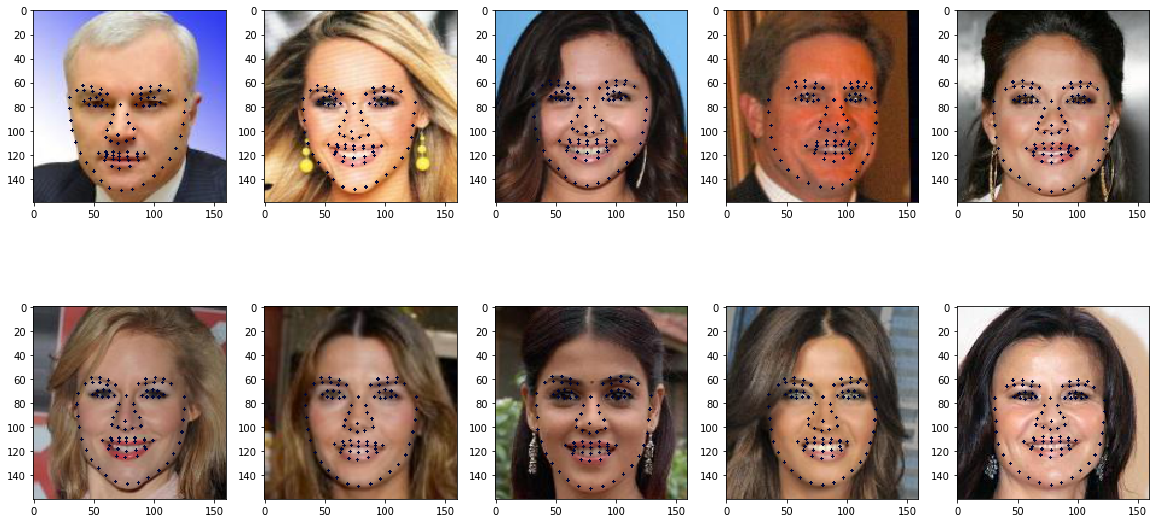

In [30]:
plt.figure(figsize=(20, 10))
num = 0
for i in range(num,num+10):
    result = draw_circle(X_train[i], flatten_lists_to_tuples(pred_y[i]))
    plt.subplot(2, 5, i+1-num)
    plt.imshow(result)

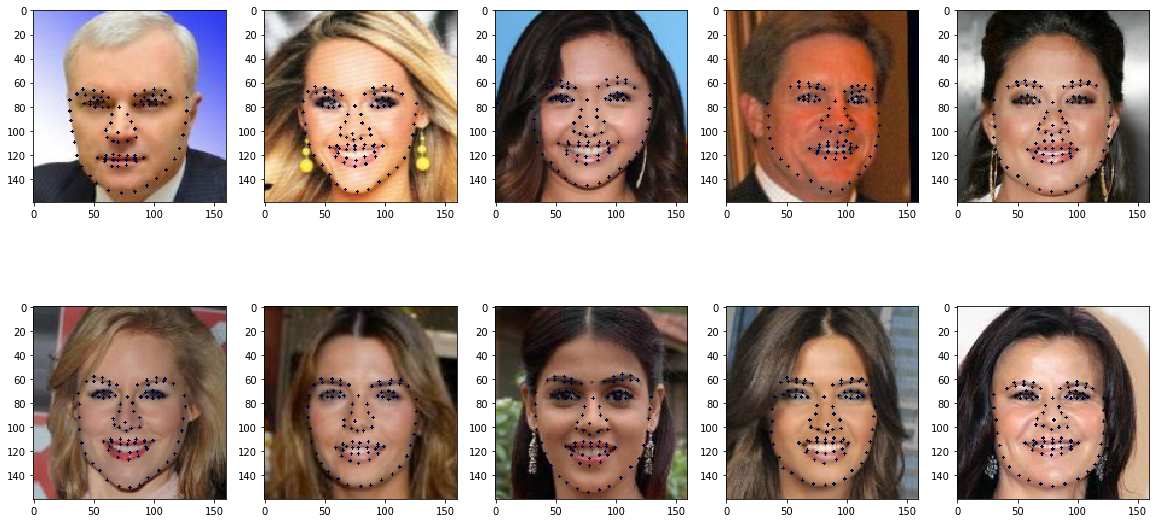

In [31]:
plt.figure(figsize=(20, 10))
num = 0
for i in range(num,num+10):
    result = draw_circle(X_train[i], flatten_lists_to_tuples(y_train[i]))
    plt.subplot(2, 5, i+1-num)
    plt.imshow(result)

## Load Dataset

In [2]:
import numpy as np
%time mini_X_train = np.load('mini_train_data/X_train.npy')
%time mini_y_train = np.load('mini_train_data/y_train.npy')
print(mini_X_train.shape,type(mini_X_train))
print(mini_y_train.shape,type(mini_y_train))

CPU times: user 1.39 ms, sys: 66.4 ms, total: 67.8 ms
Wall time: 69.9 ms
CPU times: user 1.11 ms, sys: 557 µs, total: 1.67 ms
Wall time: 1.63 ms
(115, 160, 160, 3) <class 'numpy.ndarray'>
(115, 176) <class 'numpy.ndarray'>


## Prediction

In [7]:
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope

with CustomObjectScope({'DepthwiseConv2D': DepthwiseConv2D, 'relu6':relu6}):
    mobilenet_facical_landmark = load_model('9_2.829.h5')


115/115 [==============================] - 10s    
1213.20344344


In [10]:
pred_y = mobilenet_facical_landmark.predict(mini_X_train)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave,imread,imresize


%matplotlib inline

import cv2

    
def draw_circle(img, dots, color=(255,250,205), thick=3):
    draw_img = np.copy(img)
    for dot in dots:
        draw_img = cv2.circle(draw_img,dot,1,color,-1,thick)
    return draw_img 

def flatten_lists_to_tuples(points):
    points = np.reshape(points,(-1,2))
    pts = tuple([(x,y) for x,y in points])
    return pts

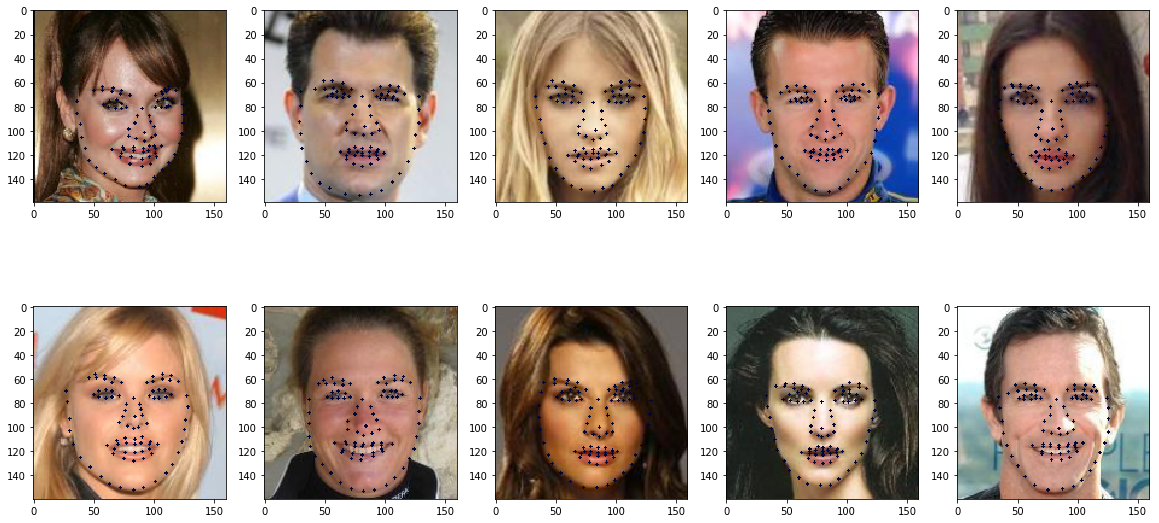

In [21]:
plt.figure(figsize=(20, 10))
num = 0
for i in range(num,num+10):
    result = draw_circle(mini_X_train[i]*255, flatten_lists_to_tuples(mini_y_train[i]))
    plt.subplot(2, 5, i+1-num)
    plt.imshow(result)